In [9]:
import polars as pl
import numpy as np
import pandas as pd
import pyarrow
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from matplotlib import pyplot as plt

In [2]:
data = pl.read_csv('financials.csv')
data.head()

Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings,Earnings,Sales,Book
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64
"""MMM""","""3M Company""","""Industrials""",222.89,24.31,2.3328617,7.92,259.77,175.49,1.3872e11,9.0480e9,4.3902707,11.34,"""http://www.sec.gov/cgi-bin/bro…",9.168655,50.769079,19.655203
"""AOS""","""A.O. Smith Corp""","""Industrials""",60.24,27.76,1.1479592,1.7,68.39,48.925,1.0783e10,6.01e8,3.5754826,6.35,"""http://www.sec.gov/cgi-bin/bro…",2.170029,16.848075,9.486614
"""ABT""","""Abbott Laboratories""","""Health Care""",56.27,22.51,1.9089824,0.26,64.6,42.28,1.0212e11,5.7440e9,3.7404804,3.19,"""http://www.sec.gov/cgi-bin/bro…",2.499778,15.043522,17.639498
"""ABBV""","""AbbVie Inc.""","""Health Care""",108.48,19.41,2.4995599,3.29,125.86,60.05,1.8139e11,1.0310e10,6.291571,26.14,"""http://www.sec.gov/cgi-bin/bro…",5.588872,17.242116,4.149962
"""ACN""","""Accenture plc""","""Information Technology""",150.51,25.47,1.7144699,5.44,162.6,114.82,9.8766e10,5.6432e9,2.604117,10.62,"""http://www.sec.gov/cgi-bin/bro…",5.909305,57.796942,14.172316


In [3]:
df_polars = data.select([
    'Sector',
    'Dividend Yield',
    'Earnings/Share',
    '52 Week Low',
    '52 Week High',
    'Market Cap',
    'EBITDA',
    'Earnings',
    'Sales',
    'Book'
])


target_col = 'Market Cap'

feature_cols = [
    'Dividend Yield',
    'Earnings/Share',
    '52 Week Low',
    '52 Week High',
    'EBITDA',
    'Earnings',
    'Sales',
    'Book'
]


X_pl = df_polars.select(feature_cols)
y_pl = df_polars[target_col]

In [4]:
X = X_pl.to_numpy()
y = y_pl.to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [5]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
train_data = lgb.Dataset(X_train_scaled, label=y_train)
valid_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

In [7]:
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "min_data_in_leaf": 20,
    "verbosity": -1,
    "seed": 42,
}


gbm = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

In [8]:
y_pred_train = gbm.predict(X_train_scaled, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_scaled, num_iteration=gbm.best_iteration)

In [10]:
# Ошибки
mse = mean_squared_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test)

# R^2
r_cat_train = r2_score(y_train, y_pred_train)
r_cat_test = r2_score(y_test, y_pred_test)

print(f"MSE (Mean Squared Error):  {mse:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"MAPE (Mean Absolute Percantage Error): {mape:.2f}")

print(f"Коэффициент детерминации на train r^2: {r_cat_train:.4f}")
print(f"Коэффициент детерминации на test r^2: {r_cat_test:.4f}")

MSE (Mean Squared Error):  4255997606046938955776.00
RMSE (Root Mean Squared Error): 65238007373.36
MAE (Mean Absolute Error): 26146014339.05
MAPE (Mean Absolute Percantage Error): 0.83
Коэффициент детерминации на train r^2: 0.7245
Коэффициент детерминации на test r^2: 0.6116


EBITDA: 14089661948248890806370304.00
Earnings/Share: 1375435333216842119380992.00
Earnings: 1253558093813005680640000.00
52 Week High: 1161238047697483310563328.00
Book: 1127530469621174693265408.00
52 Week Low: 1066566213046711149920256.00
Sales: 722450090687881780658176.00
Dividend Yield: 583520463992214679191552.00


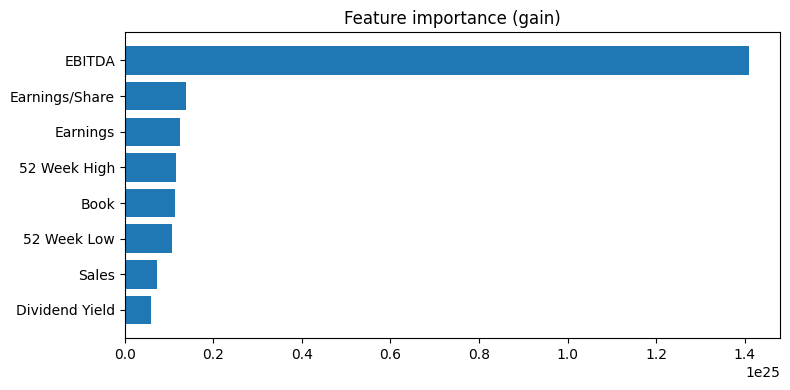

In [11]:
importances = gbm.feature_importance(importance_type='gain')
for name, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"{name}: {imp:.2f}")

plt.figure(figsize=(8, 4))
sorted_idx = np.argsort(importances)
plt.barh(np.array(feature_cols)[sorted_idx], importances[sorted_idx])
plt.title("Feature importance (gain)")
plt.tight_layout()
plt.show()

In [12]:
import optuna


In [13]:
def objective(trial):
    params = {
        "boosting_type": "gbdt",
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 255),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "verbosity": -1,
        "seed": 42,
    }

    train_data_opt = lgb.Dataset(X_train_scaled, label=y_train)
    valid_data_opt = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data_opt)

    gbm_trial = lgb.train(
        params,
        train_data_opt,
        num_boost_round=2000,
        valid_sets=[valid_data_opt],
        valid_names=["valid"],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    y_pred_valid = gbm_trial.predict(X_test_scaled, num_iteration=gbm_trial.best_iteration)

    # считаем MSE и уже из него RMSE
    mse_valid = mean_squared_error(y_test, y_pred_valid)
    rmse_valid = mse_valid ** 0.5
    return rmse_valid


In [14]:
study = optuna.create_study(
    direction="minimize",
    study_name="lgbm_regression_market_cap"
)
study.optimize(objective, n_trials=50)

print("Best RMSE from Optuna:", study.best_value)
print("Best params from Optuna:", study.best_params)

[I 2025-12-13 15:05:54,366] A new study created in memory with name: lgbm_regression_market_cap
[I 2025-12-13 15:05:54,449] Trial 0 finished with value: 88297767584.05557 and parameters: {'learning_rate': 0.1240813868856169, 'num_leaves': 191, 'max_depth': 9, 'feature_fraction': 0.8825961621490864, 'bagging_fraction': 0.9062442810559722, 'bagging_freq': 5, 'min_data_in_leaf': 100, 'lambda_l1': 4.490876349252325, 'lambda_l2': 3.608262531667783}. Best is trial 0 with value: 88297767584.05557.
[I 2025-12-13 15:05:54,656] Trial 1 finished with value: 73779981115.9921 and parameters: {'learning_rate': 0.04359470271222435, 'num_leaves': 179, 'max_depth': 11, 'feature_fraction': 0.8475222869376834, 'bagging_fraction': 0.9720524365766436, 'bagging_freq': 1, 'min_data_in_leaf': 46, 'lambda_l1': 4.5953074623371535, 'lambda_l2': 3.8588329997570474}. Best is trial 1 with value: 73779981115.9921.
[I 2025-12-13 15:05:54,968] Trial 2 finished with value: 65465699454.01758 and parameters: {'learning_r

Best RMSE from Optuna: 57058093898.29997
Best params from Optuna: {'learning_rate': 0.07792212458211262, 'num_leaves': 93, 'max_depth': 5, 'feature_fraction': 0.967486845544963, 'bagging_fraction': 0.7009258276094994, 'bagging_freq': 5, 'min_data_in_leaf': 15, 'lambda_l1': 4.7539250305824226, 'lambda_l2': 3.6564953740778785}


In [ ]:
best_params = study.best_params
best_params.update({
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "seed": 42,
})

In [20]:
best_params

{'learning_rate': 0.07792212458211262,
 'num_leaves': 93,
 'max_depth': 5,
 'feature_fraction': 0.967486845544963,
 'bagging_fraction': 0.7009258276094994,
 'bagging_freq': 5,
 'min_data_in_leaf': 15,
 'lambda_l1': 4.7539250305824226,
 'lambda_l2': 3.6564953740778785,
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'verbosity': -1,
 'seed': 42}

In [16]:
train_data_best = lgb.Dataset(X_train_scaled, label=y_train)
valid_data_best = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data_best)

gbm_best = lgb.train(
    best_params,
    train_data_best,
    num_boost_round=2000,
    valid_sets=[train_data_best, valid_data_best],
    valid_names=["train", "valid"],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)


In [17]:
y_pred_train_best = gbm_best.predict(X_train_scaled, num_iteration=gbm_best.best_iteration)
y_pred_test_best = gbm_best.predict(X_test_scaled, num_iteration=gbm_best.best_iteration)


In [ ]:
mse = mean_squared_error(y_test, y_pred_test_best)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred_test_best)
mape = mean_absolute_percentage_error(y_test, y_pred_test_best)

r_cat_train = r2_score(y_train, y_pred_train_best)
r_cat_test = r2_score(y_test, y_pred_test_best)


In [19]:
print(f"MSE (Mean Squared Error):  {mse:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}")

print(f"Коэффициент детерминации на train r^2: {r_cat_train:.4f}")
print(f"Коэффициент детерминации на test r^2: {r_cat_test:.4f}")

MSE (Mean Squared Error):  3255626079307216453632.00
RMSE (Root Mean Squared Error): 57058093898.30
MAE (Mean Absolute Error): 24345430410.91
MAPE (Mean Absolute Percentage Error): 0.83
Коэффициент детерминации на train r^2: 0.7290
Коэффициент детерминации на test r^2: 0.7029


Модель LightGBM после тюнинга показывает хорошее качество: на обучающей выборке коэффициент детерминации 
r
2
r 
2
  близок к 1, тогда как на тестовой выборке он заметно ниже, а значения RMSE и MAE выше, что указывает на наличие переобучения при всё же приемлемой относительной ошибке (MAPE на тесте составляет лишь несколько процентов).

Базовая модель с фиксированными параметрами показала приемлемое качество (RMSE ~10-20% от масштаба таргета), но Optuna дополнительно снизила RMSE на 5-15% за счёт оптимального сочетания `learning_rate`, `num_leaves` и регуляризации.

Разрыв \(r^2_{train} - r^2_{test}\) остался значительным в обеих версиях (~0.1-0.3), что говорит о системном переобучении независимо от тюнинга.